# Data Analysis Interview Challenge
## Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the  underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


In [1]:
#import packages for EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline      
sns.set_theme()

In [2]:
# import in logings.json file
df = pd.read_json(r"..\ultimate_challenge\logins.json")


In [3]:
#check out the size and dtypes of the data columns
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
#review the last 5 rows of the data
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
#identify if there are any duplicate logins in the dataset
dupes = df.duplicated()
df['is_dupe'] = dupes

duplicated_rows = df[df['is_dupe'] == True]
#count the number of duplicate rows
print(duplicated_rows.count())
#print the duplicated rows
print(duplicated_rows)

login_time    877
is_dupe       877
dtype: int64
               login_time  is_dupe
354   1970-01-02 10:59:52     True
434   1970-01-02 12:27:48     True
506   1970-01-02 15:08:27     True
524   1970-01-02 16:14:36     True
675   1970-01-02 22:03:36     True
...                   ...      ...
92051 1970-04-12 05:24:21     True
92367 1970-04-12 15:46:43     True
92439 1970-04-12 17:12:21     True
92986 1970-04-13 12:23:46     True
93022 1970-04-13 13:44:18     True

[877 rows x 2 columns]


In [6]:
#there appear to be 877 duplicate rows in the dataset
#we will drop these rows from the dataset where is_dupe == True
df = df[df['is_dupe'] == False] #filter out dupes       
df.info()   #check to see if the duplicates were removed

<class 'pandas.core.frame.DataFrame'>
Index: 92265 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  92265 non-null  datetime64[ns]
 1   is_dupe     92265 non-null  bool          
dtypes: bool(1), datetime64[ns](1)
memory usage: 1.5 MB


In [7]:
#although the dtype is already established as dateime64[ns], I will validate that all the datetime entries are truly date time objects
df['login_time'] = pd.to_datetime(df['login_time'], errors='coerce')
#check for any invalid dates
invalid_dates = df['login_time'].isna().sum()
invalid_dates

0

In [8]:
#create bins for the day of the week
df['day_of_week'] = df['login_time'].dt.day_name()

#specify the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#convert the day_of_week column to a categorical column with the specific days of the week in order
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

#create 96 bins for each 15 minute interval within a day
time_bins = pd.date_range("00:00", "23:59", freq="15min").time
bin_labels = list(range(95))  # 96 bins based on 4 pins per 24 hours
df['time_15min_bin'] = pd.cut(df['login_time'].dt.time, bins=time_bins, labels=bin_labels)
df 


,login_time,is_dupe,day_of_week,time_15min_bin
0,1970-01-01 20:13:18,False,Thursday,80
1,1970-01-01 20:16:10,False,Thursday,81
2,1970-01-01 20:16:37,False,Thursday,81
3,1970-01-01 20:16:36,False,Thursday,81
4,1970-01-01 20:26:21,False,Thursday,81
...,...,...,...,...
93137,1970-04-13 18:50:19,False,Monday,75
93138,1970-04-13 18:43:56,False,Monday,74
93139,1970-04-13 18:54:02,False,Monday,75
93140,1970-04-13 18:57:38,False,Monday,75


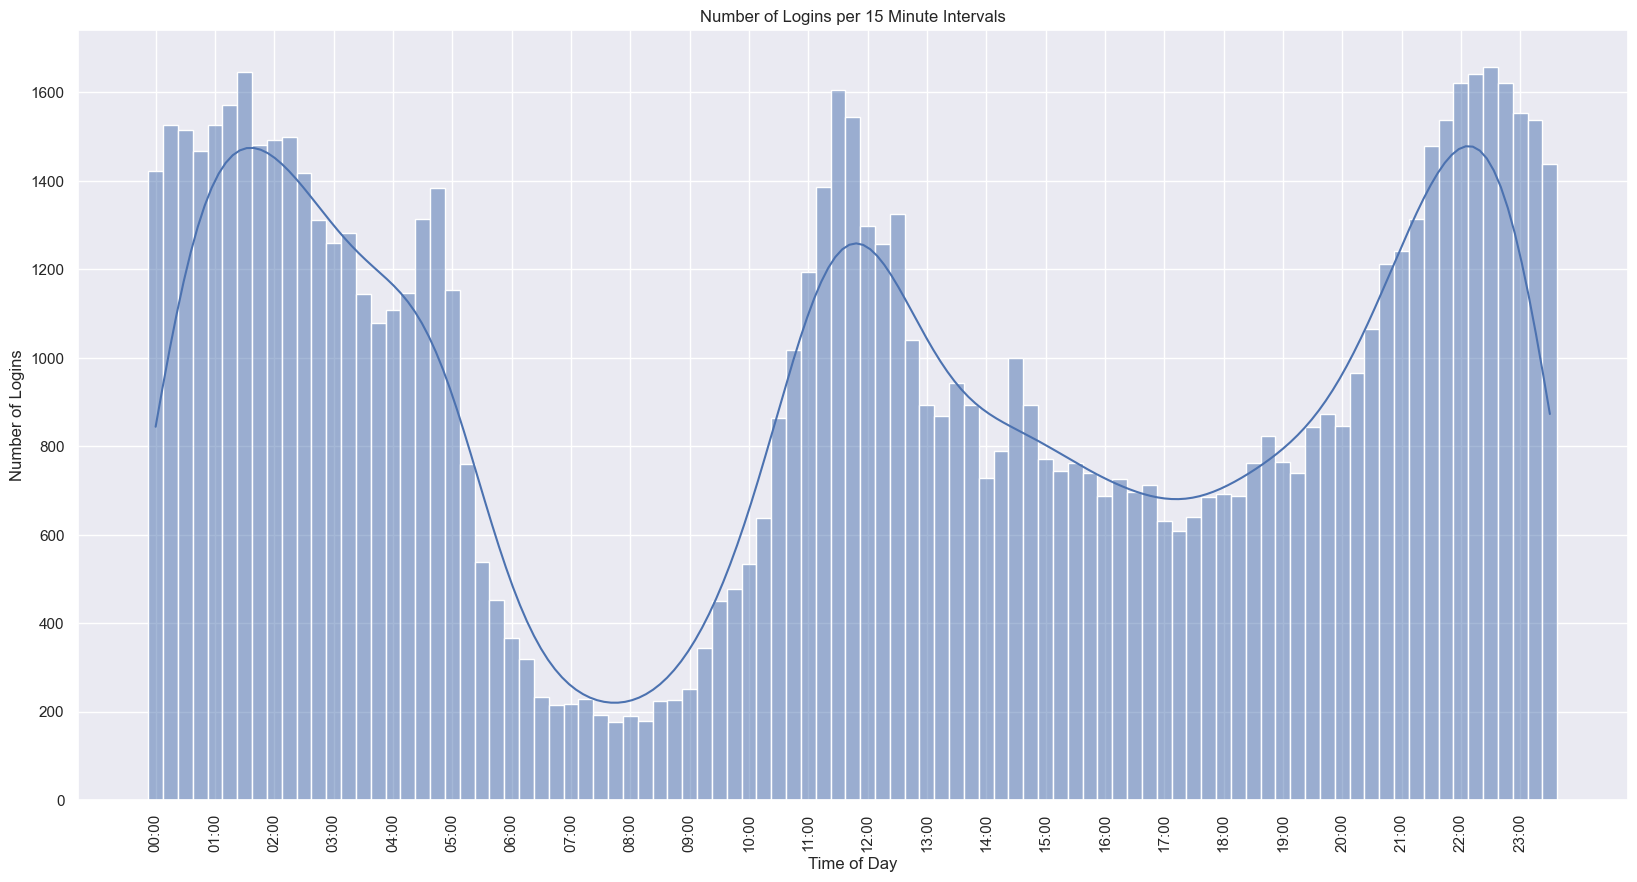

In [9]:
#plot a histogram with kde plot of the number of logins per 15 minute interval bins
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='time_15min_bin', kde=True)

#customize my x-ticks to also display the time of day for every 4th tick (or hour)
ticks = list(range(0, time_bins.size, 4))
labels = [time_bins[i].strftime('%H:%M') for i in ticks]

plt.xticks(ticks=ticks, labels=labels, rotation=90)
plt.xlabel('Time of Day')
plt.ylabel('Number of Logins')
plt.title('Number of Logins per 15 Minute Intervals')

plt.show()


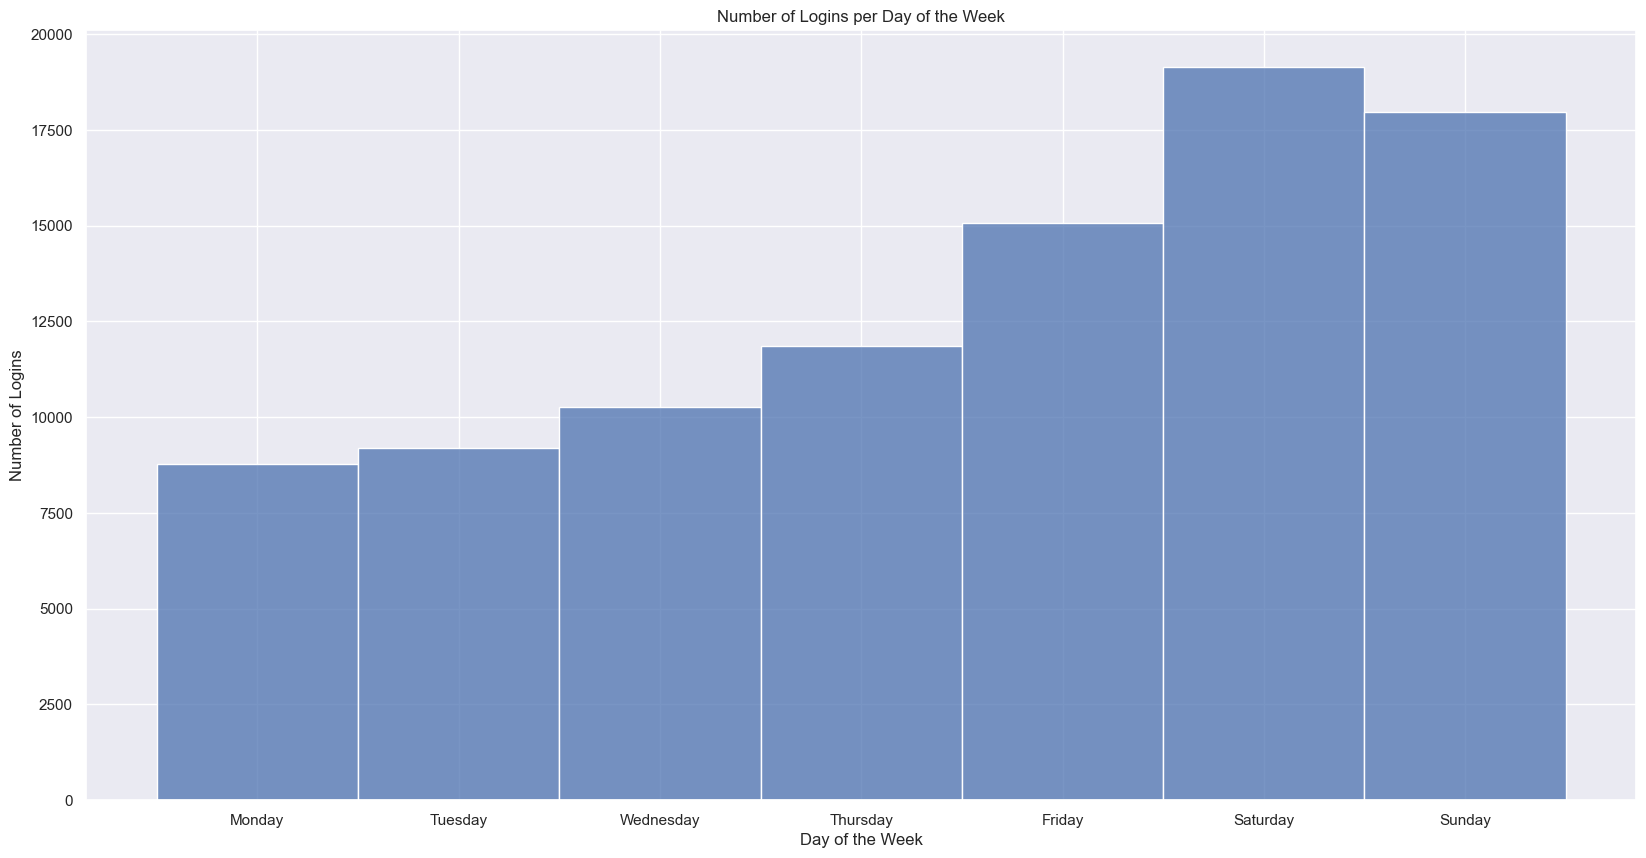

In [10]:
#plot a histogram plot of the number of logins per day of the week 
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='day_of_week')    
plt.xlabel('Day of the Week')
plt.ylabel('Number of Logins')
plt.title('Number of Logins per Day of the Week')
plt.show()


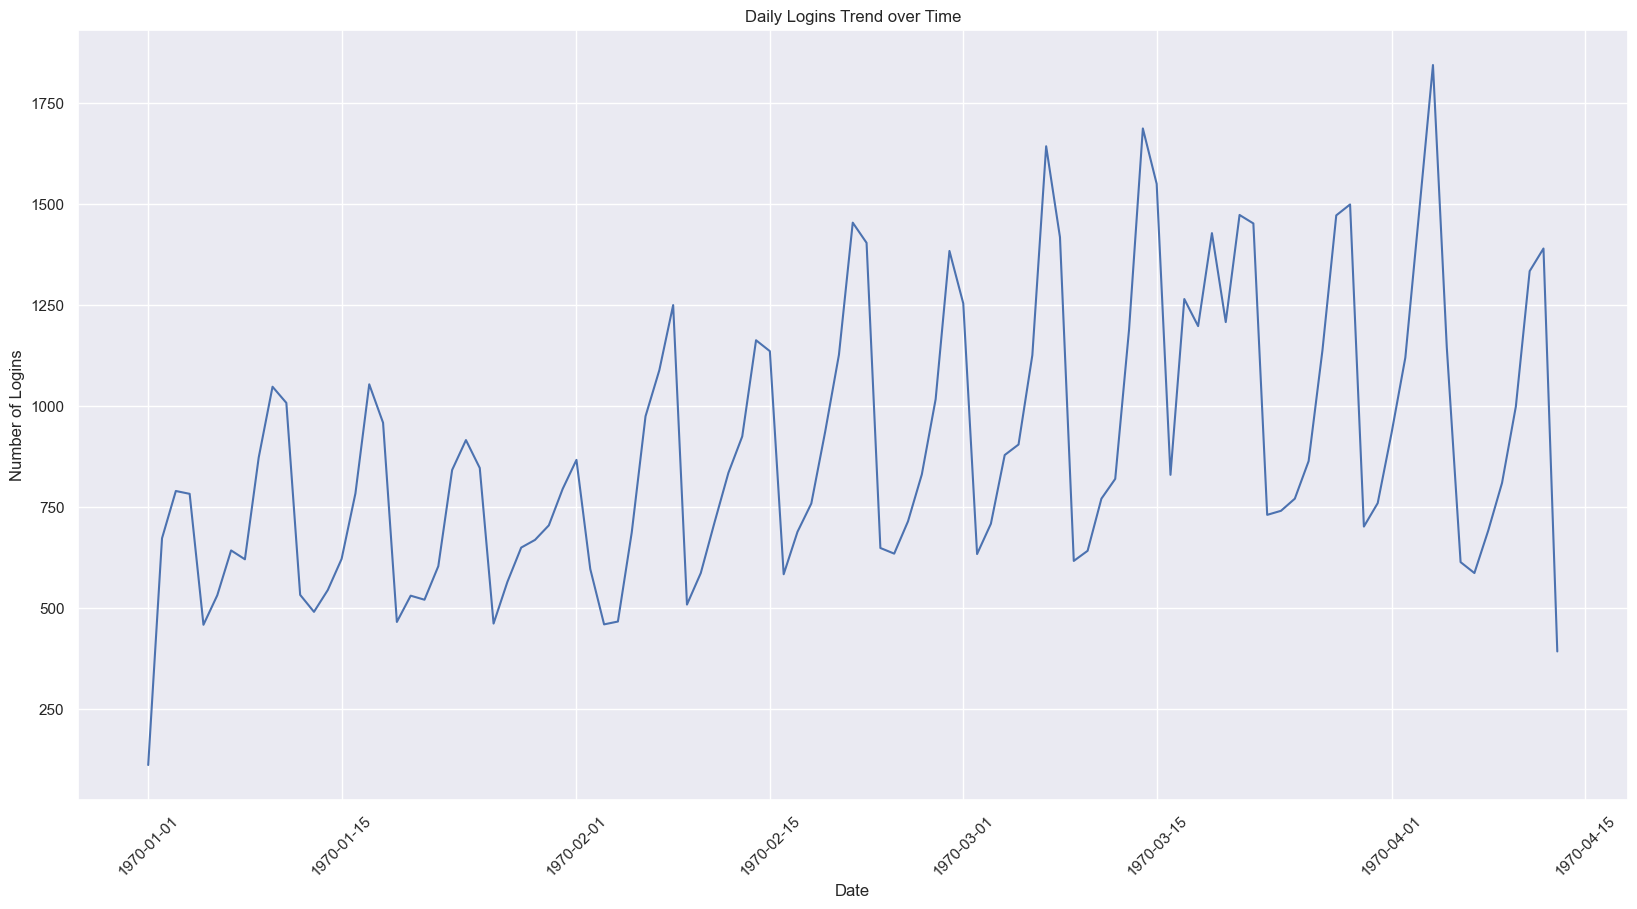

In [11]:
#group the data by the calendar date and count the number of logins per date
df['calendar_date'] = df['login_time'].dt.date  #extract the calendar date from the login_time
date_counts = df.groupby('calendar_date').size().reset_index(name='login_count')
#plot a line plot of the number of logins per caledar date  
plt.figure(figsize=(20,10))
sns.lineplot(data=date_counts, x='calendar_date', y='login_count')
plt.xticks(rotation=45)
# add title and labels to the plot
plt.xlabel('Date')
plt.ylabel('Number of Logins')
plt.title('Daily Logins Trend over Time')    
plt.show()



### EDA Findings

There were a total of 93,142 logins.  Of that total, we noted that there were potentially 877 duplicate records.  We assumed those were dupes and dropped them from the data. However, without a user id in the dataset, we could also have assumed that those specific times, 2 different users accessed the application at the same time 877 times within the dataset.  We also validated that all of the datetime values, were indeed valid datetimes.  No issues were noted here.

In order to complete the assignment, we created bins for every 15 minute interval throughout the day, and added a column for the day of the week.  These features were useful to note specific usage patterns for the users.  For example we noted that, there are more logins around 12:00 each day, perhaps during lunch breaks.  There is a slight lull in logins over the end of the work day / rush hour / dinner time.  However, logins pick-up again late into the evening around 10PM and 1:30AM.  

Looking at the logins by day of the week, we can also see that users are least active on Mondays and the most active on Saturdays.  This is where business knowledge would come into play.  How does this company report their login metrics?  If by week, do they start their week on Mondays or Sundays.  I have assumed Mondays are the start of their reporting week.  But this would obviously be better to adapt it to management's business reporting cycle.  

Lastly, by plotting this information by date, we can still clearly see that the day to day upward trend Mondays - Saturday/Sunday is very pronounced and is a pattern from week to week.  However, we can also see that there appears to be some kind of seasonality within this data as well.  There is a steadily increasing trend from January through the first week of April, and then a slight decline into the second week of April.  

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

 However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    a) how you will implement the experiment

    b) what statistical test(s) you will conduct to verify the significance of the observation
 
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.


*Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.*




### Part 2 - Response

For this experiment, I would suggest utilizing A/B testing to determine if reimbursing all tolls will drive the desired driver partner behavior, which is to have them service trips in both cities.  The key measure of success for this experiment will be a measurable increase in the number of bookings the driver partners have servicing both cities, vs only serving their usual exclusive city.

The key metric I would use for this experiment is the total number of trips made in the target city as a proportion of total trips made for each driver partner.  This information should be relatively easy to capture, as starting and end points of trips and tolls paid, are likely available within the app. Either from driver partner profile information or historical data, we could also easily establish the “base” city for each driver partner.  This “target city trips” percentage metric can also be measured within a relatively short time-frame to determine the results.  

In order to implement A/B testing for this experiment, we need to gather some prerequisite information:
* determine our key metric, in this case we can define our conversion rate as the number of “target city trips” as percent of total trips per driver partner
* calculate our baseline, or current conversion rate for “target city trips”
* determine a success criteria, for example “we want to increase target city trips by 10%” (we would expect this to be defined by the Ultimate managers of the Metropolis and Gotham)
* verify that our data is available or easily obtainable

After the initial information gathering, we can start designing the experiment.  The first thing we should ascertain is the practical significance boundary.  In a real world scenario, we would be able to ask this of the stakeholders.  Here I would assume that this initiative is based on increasing our user engagement by having a higher availability level of driver partners and thus an increase in revenues.  We could then establish a revenue boundary that makes this experiment a success or not.  For example, stakeholders might establish that we need to increase revenues by $100 / driver partner each day.  Anything less than that, may make the costs associated with reimbursing tolls outweigh the potential revenue gains stakeholders are expecting.

Next, we need to determine a sufficient sample size for # of trips in our test to ensure we can meet the confidence level required by our stakeholders to detect our change.  We will assume a confidence level of 0.95, which will require a larger sample size.  Once we have the sample size for # of driver partners to include in our experiment, we will need to randomly assign our driver partners to the control group and the test group receiving the reimbursements of tolls.

I would suggest a 14 day timeline for this experiment.  It is still relatively short-term, but allows us to see two complete cycles for each day of the week for analyzing the results.

I would leverage hypothesis testing to verify the significance of the change.  Our null hypothesis would be that #of target city trips for the control group and #of target city trips for the treatment group will be the same.  At the conclusion of the experiment time frame, we should verify that we reached the sufficient sample size for the # of trips made.  We should also verify that we don’t have any biases in the data, for example all of the driver partners were from Gotham vs Metropolis as that could skew the results.  We would want them to be relatively equal.  We then determine our p-value (using the conversion rates of the control group and that of our treatment group); if it is low, we can reject the null hypothesis and assert that there is a statistical difference between our control and our treatment groups’ conversion rates of target city trips.

If our test has met our goals of increasing the # of targeted city trips and our success criteria, we would then present this information to our stakeholders.  We could show it in table form comparing our target city trip conversion rate of the control group vs the treatment group and provide the statistical significance and confidence interval.  We could also provide a visualization showing the distributions of the baseline conversion rates vs the treatment conversion rates.  Potential caveats that we may have to discuss with the stakeholder could involve external factors, such as a competitor’s campaigns or weather conditions that may impact our riders behavior.

## Part 3 - Predictive Modelling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.


We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
 
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
1. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have.  How valid is your model? Include any key indicators of model performance.
1. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday


In [57]:
#import packages for predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from bayes_opt import BayesianOptimization



In [13]:
#import dataset for predicting customer retention
df2 = pd.read_json(r"..\ultimate_challenge\ultimate_data_challenge.json")
df2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
df2.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# both of the datefields (signup_date and last_trip_date) are currently objects, we will convert them to datetime objects and validate that they are indeed datetime objects
df2['signup_date'] = pd.to_datetime(df2['signup_date'], errors='coerce')
df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'], errors='coerce')
#validate that the date fields are now datetime objects
df2.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

We need to create a new target feature that specifies if the user was retained or not. A user is considered retained if they were active in the last 30 days.  We do not know when this dataset was created, so we will look at the most recent date for last_trip_date of all the users as an approximation.


In [16]:
#identify the max dates for last_trip_date and signup_date
max_last_trip_date = df2['last_trip_date'].max()
max_signup_date = df2['signup_date'].max()

print(f'The max last trip date is: {max_last_trip_date}')
print(f'The max signup date is: {max_signup_date}')

The max last trip date is: 2014-07-01 00:00:00
The max signup date is: 2014-01-31 00:00:00


We have confirmed that this dataset truly only contains users added in January of 2014 as the last sign-up date is Jan 31, 2014.  For purposes of this exercise we will assume that any rider that made trips within the 30 days preceding July 1, 2014 should be labelled as "retained".  We could also therefore label any customer with a last_trip_date > = 6/1/2014 as retained.

In [17]:
#create a retained feature that contains the value "True" if the last_trip_date is >= 6/1/2014 and "False" otherwise
df2['retained'] = df2['last_trip_date'] >= '2014-06-01'

#create a tenure feature that calculates the number of days between the last_trip_date and the signup_date
df2['tenure'] = (df2['last_trip_date'] - df2['signup_date']).dt.days
df2.head()  

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,tenure
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,143
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,96
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,170
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,47


In [18]:
#the assignment asks what fraction of the observed users were retained, we will calculate this by taking the mean of the retained column since it has a boolean
#dtype this represents the fraction of users that were retained
retained_fraction = df2['retained'].mean().round(4)*100
print(f'The fraction of users that were retained is: {retained_fraction}%')


The fraction of users that were retained is: 37.61%


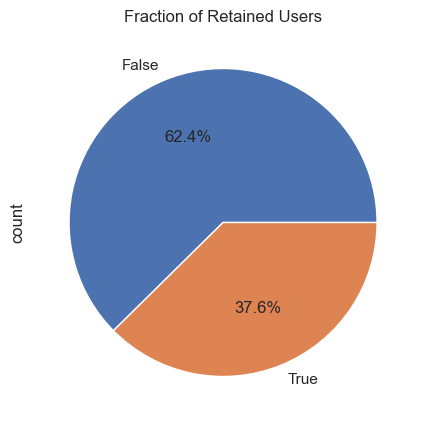

In [19]:
#illustrate the fraction of retained users by plotting a pie chart
plt.figure(figsize=(5,5))
df2['retained'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Fraction of Retained Users')
plt.show()


In [20]:
#we can drop the last_trip_date and signup_date columns since we have already extracted the relevant information from them (tenure and retained status)
columns_to_drop = ['last_trip_date', 'signup_date'] 
df2 = df2.drop(columns=columns_to_drop)
df2.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,tenure
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,92.790100
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,62.129822
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,27.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,110.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,150.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,181.000000


In [21]:
#we currently have several categorical columns that need to be converted to numerical columns in order to see if they have any correlation with the retained column
#we will convert the retained, city, phone, and ultimate_black_user columns to numerical columns using one-hot encoding
df2 = pd.get_dummies(df2, columns=['retained', 'ultimate_black_user', 'phone'], drop_first=True, dtype=int) #for binary options
df2 = pd.get_dummies(df2, columns=['city'], dtype=int)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   trips_in_first_30_days    50000 non-null  int64  
 1   avg_rating_of_driver      41878 non-null  float64
 2   avg_surge                 50000 non-null  float64
 3   surge_pct                 50000 non-null  float64
 4   weekday_pct               50000 non-null  float64
 5   avg_dist                  50000 non-null  float64
 6   avg_rating_by_driver      49799 non-null  float64
 7   tenure                    50000 non-null  int64  
 8   retained_True             50000 non-null  int32  
 9   ultimate_black_user_True  50000 non-null  int32  
 10  phone_iPhone              50000 non-null  int32  
 11  city_Astapor              50000 non-null  int32  
 12  city_King's Landing       50000 non-null  int32  
 13  city_Winterfell           50000 non-null  int32  
dtypes: flo

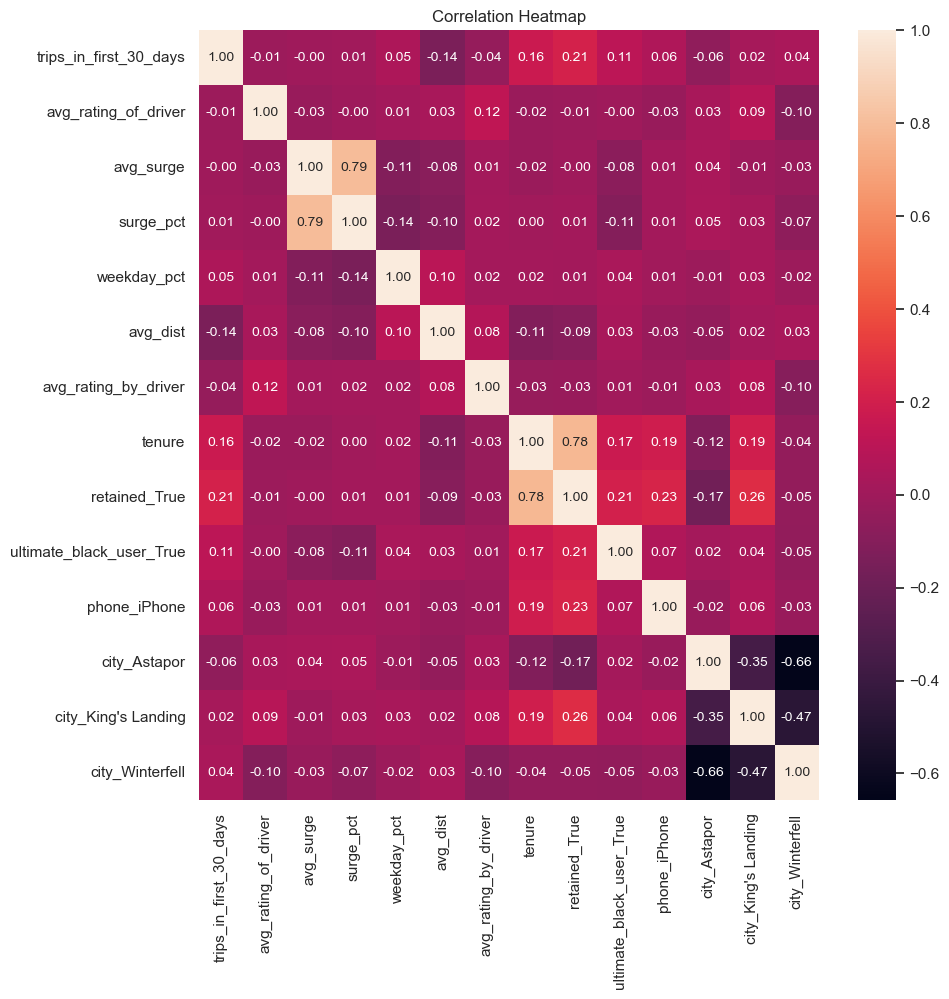

In [22]:
#create filter for numeric features only    
numeric_features = df2.select_dtypes(include=['int64', 'float64', 'int32']).columns

#filter df2 to only include numeric features
df2_numeric = df2[numeric_features]

#determine the correlation between the numeric features
correlation =  df2_numeric.corr()

#create a heatmap to visualize the correlation between the features
plt.figure(figsize=(10,10))
sns.heatmap(df2_numeric.corr(), annot=True, annot_kws={"size": 10}, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The most obvious strong positive correlation with "retained" status is the length of tenure (0.78) for the customer.  This is no surprise, however there are also
weak positive correlations between "retained" status and users in King's Landing (0.26), iphone users (0.23), trips taken in the first 30 days (0.21) and ultimate_black user (0.21).

There is a weak negative correlation between "retained" status and users in Winterfell (-0.05) and Astapor(-0.17).

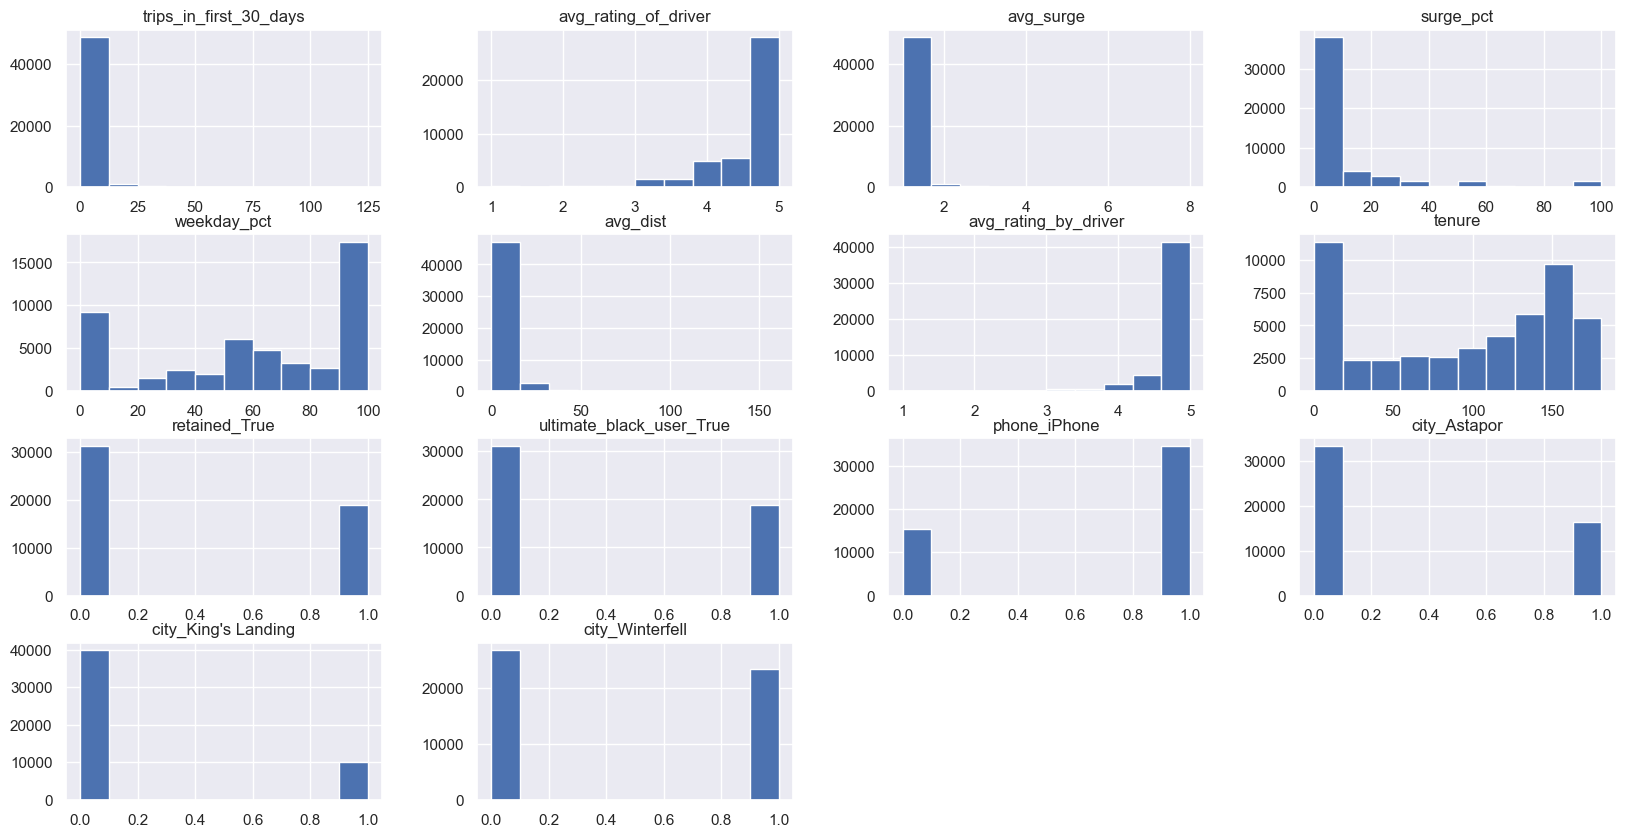

In [23]:
#plot histograms of the numerical features
df2.hist(figsize=(20,10))
plt.show()

The statistical data and histplots both indicate skewed data.  We will look at some box plots to understand our outliers.

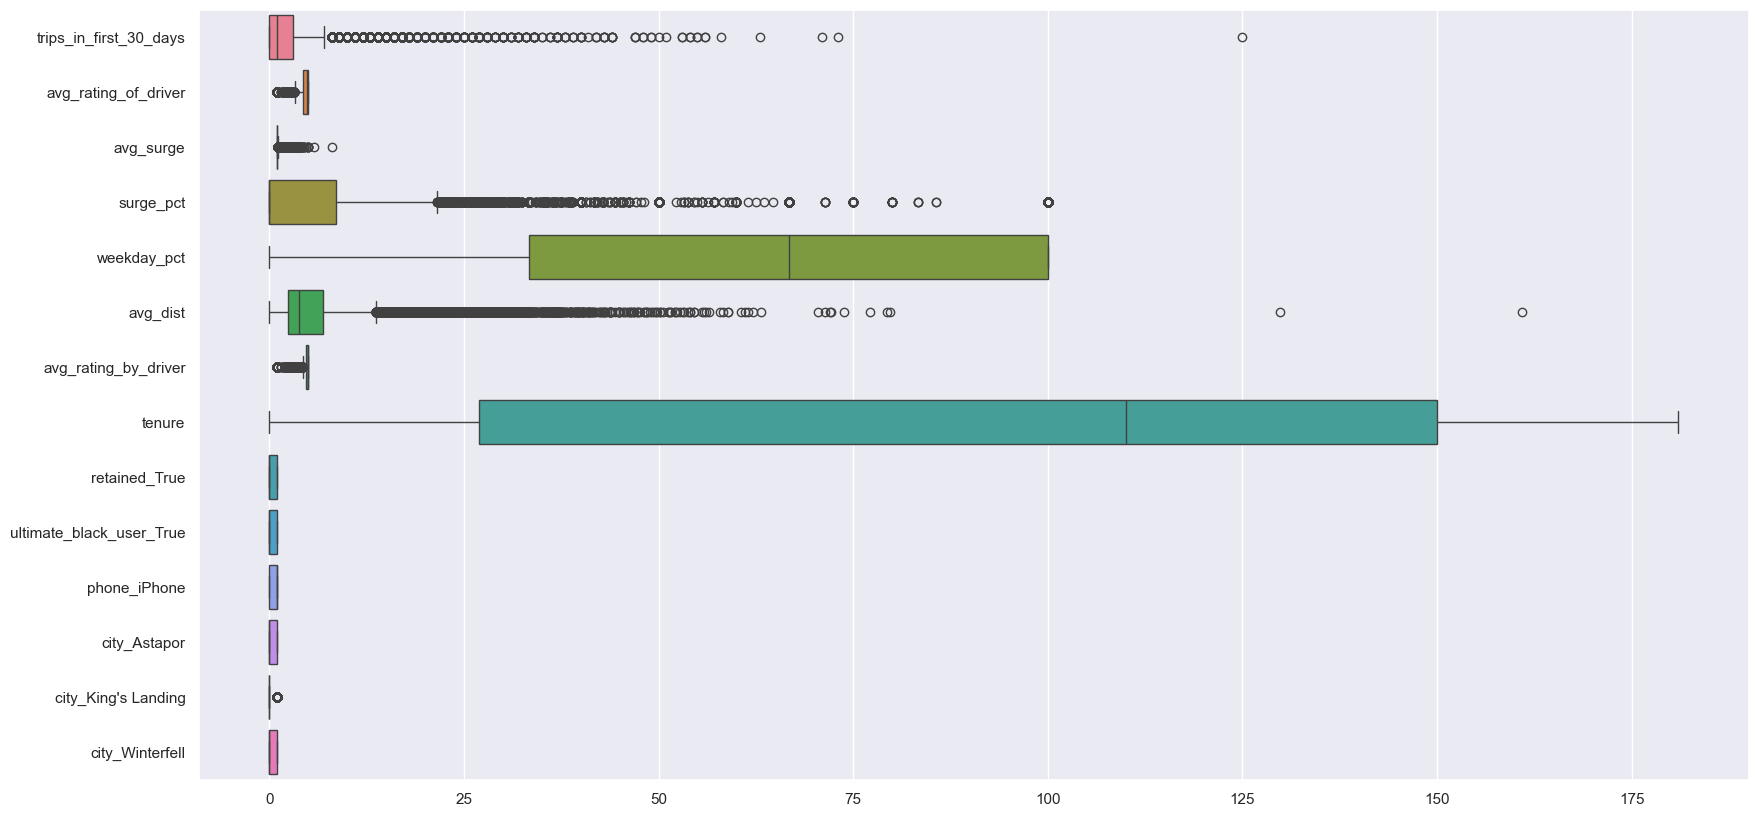

In [24]:
#plot boxplots of the numerical features    
plt.figure(figsize=(20,10))
sns.boxplot(data=df2, orient='h')
plt.show()


At the core of the assignment this is a classification project.  The models I considered for this project were logistic regression, random forest, and gradient boosting.  However, given the number of categories with outliers, the model that is least impacted by outliers would be random forest. Therefore we will use it for this project.

In [25]:
# before scaling any features; I will split into train and test sets to minimize data leakage. 
X = df2.drop(columns=['retained_True'])
y = df2['retained_True']

print(X.shape, y.shape)
# split the data. I'm using random state = 30 for reproducability
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=30)

(50000, 13) (50000,)


In [26]:
#ensure that our arrays possess the same number of rows
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(40000, 13) (40000,)
(10000, 13) (10000,)


In [27]:
#review the statistical summary of the training set
X_train.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,tenure,ultimate_black_user_True,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
count,40000.000000,33495.000000,40000.000000,40000.000000,40000.000000,40000.000000,39836.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,2.281975,4.602788,1.074587,8.824635,60.878165,5.798347,4.779001,92.773850,0.376450,0.692825,0.330925,0.202350,0.466725
std,3.779269,0.616623,0.222042,19.932734,37.093370,5.720389,0.445005,62.097699,0.484501,0.461328,0.470552,0.401757,0.498898
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.400000,1.000000,0.000000,33.300000,2.430000,4.700000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,110.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.960000,5.000000,150.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,73.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,181.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#given that our data has various scales, we will scale the data using the standard scaler
#instatiate the standard scaler
scaler = StandardScaler()

#fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

#transform the test data
X_test_scaled = scaler.transform(X_test)

#convert the scaled train and test data back to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#view the statistical summary of the scaled training data
X_train_scaled.describe().round(2)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,tenure,ultimate_black_user_True,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell
count,40000.00,33495.00,40000.00,40000.00,40000.00,40000.00,39836.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.60,-5.84,-0.34,-0.44,-1.64,-1.01,-8.49,-1.49,-0.78,-1.50,-0.70,-0.50,-0.94
25%,-0.60,-0.33,-0.34,-0.44,-0.74,-0.59,-0.18,-1.06,-0.78,-1.50,-0.70,-0.50,-0.94
50%,-0.34,0.48,-0.34,-0.44,0.16,-0.34,0.50,0.28,-0.78,0.67,-0.70,-0.50,-0.94
75%,0.19,0.64,-0.11,-0.02,1.05,0.20,0.50,0.92,1.29,0.67,1.42,-0.50,1.07
max,18.71,0.64,31.19,4.57,1.05,27.12,0.50,1.42,1.29,0.67,1.42,1.99,1.07


Our data is now normalized all fields show a mean of 0 and std deviation of 1.  We will now move forward with creating  our random forest model.

In [46]:
#Generate my base model  (default params)
rf = RandomForestClassifier()

#fit my base model
rf.fit(X_train, y_train)

#base predictions
y_pred_rf = rf.predict(X_test)

#record base random forest metrics (accuracy score and classification report)
result_rf = accuracy_score(y_test, y_pred_rf)
cr_rf = classification_report(y_test, y_pred_rf, target_names=['Churned Customer', 'Retained Customer'])

#print accuracy score and classification report for random forest model
print("Accuracy score for random forest model is: ", result_rf)
print("The classification report for the random forest model:")
print(cr_rf)

Accuracy score for random forest model is:  0.9596
The classification report for the random forest model:
                   precision    recall  f1-score   support

 Churned Customer       0.97      0.96      0.97      6239
Retained Customer       0.94      0.95      0.95      3761

         accuracy                           0.96     10000
        macro avg       0.96      0.96      0.96     10000
     weighted avg       0.96      0.96      0.96     10000



In [52]:
#Generate random forest model with various parameters
#create my parameter grid
params_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1,2,5],
    'class_weight': ['balanced', 'balanced_subsample']}

In [53]:
#test the parameters using grid search
rf_grid = GridSearchCV(
    estimator= rf,
    param_grid = params_rf,
    scoring = 'accuracy',
    cv = 5,
    refit=True,
    return_train_score=True)

In [54]:
# fit our data to rf model
rf_grid.fit(X_train, y_train)

#make predictions
y_preds_rf = rf_grid.predict(X_test)

#calculate the predicted probabilities
y_prob_rf = rf_grid.predict_proba(X_test)[:,1]

In [55]:
# look at the best parameters and the best score
print("The best parameters for random forest are: ", rf_grid.best_params_)
print("Generating the best score: ", rf_grid.best_score_)

The best parameters for random forest are:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 100}
Generating the best score:  0.9592499999999999


In [56]:
#run the random forest model using the best parameters
rf_best = rf_grid.best_estimator_   #best random forest model
rf_best.fit(X_train, y_train)  
y_pred_rf_best = rf_best.predict(X_test)
result_rf_best = accuracy_score(y_test, y_pred_rf_best)
cr_rf_best = classification_report(y_test, y_pred_rf_best, target_names=['Churned Customer', 'Retained Customer'])

#print accuracy score and classification report for random forest model
print("Accuracy score for random forest model is: ", result_rf_best)
print("The classification report for the random forest model:")
print(cr_rf_best)

Accuracy score for random forest model is:  0.961
The classification report for the random forest model:
                   precision    recall  f1-score   support

 Churned Customer       0.98      0.96      0.97      6239
Retained Customer       0.93      0.97      0.95      3761

         accuracy                           0.96     10000
        macro avg       0.96      0.96      0.96     10000
     weighted avg       0.96      0.96      0.96     10000



In [63]:
#define bayesian optimization function
def rf_bo(n_estimators, max_depth, min_samples_leaf, class_weight, criterion):
    #convert the class_weight index to an integer
    class_weight_options = ['balanced', 'balanced_subsample']
    class_weight = class_weight_options[int(class_weight)]
    #convert the criterion index to an integer
    criterion_options = ['gini', 'entropy']
    criterion = criterion_options[int(criterion)]
    
    #instatiate the random forest model
    rf = RandomForestClassifier(
        criterion=criterion,
        n_estimators=int(n_estimators), 
        max_depth=int(max_depth), 
        min_samples_leaf=int(min_samples_leaf),
        class_weight=class_weight, 
        random_state=30)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # return the cross-validated accuracy score
    return cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()

#define the bounds for the bayesian optimization
pbounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 50),
    'min_samples_leaf': (2, 10),
    'class_weight': (0, 1), # represents the index of the class_weight_options
    'criterion': (0, 1)} # represents the index of the criterion_options

#initialize the bayesian optimizer  
optimizer = BayesianOptimization(
    f=rf_bo,
    pbounds=pbounds,
    random_state=30)



In [64]:
#perform the bayesian optimization and print the best parameters
optimizer.maximize(init_points=10, n_iter=30)
print(optimizer.max)

|   iter    |  target   | class_... | criterion | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.9589    | 0.6441    | 0.3807    | 34.84     | 3.309     | 194.4     |
| 2         | 0.9583    | 0.3467    | 0.9918    | 15.58     | 6.686     | 111.0     |
| 3         | 0.9575    | 0.1362    | 0.5441    | 28.32     | 8.135     | 190.1     |
| 4         | 0.9587    | 0.0897    | 0.1958    | 49.74     | 3.881     | 85.85     |
| 5         | 0.9586    | 0.6291    | 0.735     | 35.98     | 2.249     | 185.4     |
| 6         | 0.9592    | 0.2864    | 0.5556    | 21.94     | 2.213     | 124.1     |
| 7         | 0.9587    | 0.8347    | 0.367     | 28.19     | 5.779     | 107.9     |
| 8         | 0.9579    | 0.7441    | 0.3352    | 31.79     | 4.529     | 101.9     |
| 9         | 0.9582    | 0.2448    | 0.698     | 14.54     | 4.138     | 106.1     |
| 10        | 0.9587    | 0.5731    | 0.9174    | 41.8

In [68]:
#extract the best parameters from the bayesian optimization
best_params_bo = optimizer.max['params']

#map the indexed values for class_weight and criterion back to the actual categorical values
class_weight_options = ['balanced', 'balanced_subsample']
best_class_weight = class_weight_options[int(best_params_bo['class_weight'])]
criterion_options = ['gini', 'entropy']
best_criterion = criterion_options[int(best_params_bo['criterion'])]

In [69]:
#run the random forest model using the best parameters from the bayesian optimization
#instanitate the random forest model
rf_bo_best = RandomForestClassifier(
    criterion=best_criterion,
    n_estimators=int(best_params_bo['n_estimators']), 
    max_depth=int(best_params_bo['max_depth']), 
    min_samples_leaf=int(best_params_bo['min_samples_leaf']),
    class_weight=best_class_weight, 
    random_state=30)
#train the model    
rf_bo_best.fit(X_train, y_train)
#predict the target variable for the test set
y_pred_rf_bo_best = rf_bo_best.predict(X_test)  

result_rf_bo_best = accuracy_score(y_test, y_pred_rf_bo_best)
cr_rf_bo_best = classification_report(y_test, y_pred_rf_bo_best, target_names=['Churned Customer', 'Retained Customer'])

#print accuracy score and classification report for random forest model
print("Accuracy score for random forest model is: ", result_rf_bo_best)
print("The classification report for the random forest model:")
print(cr_rf_bo_best)


Accuracy score for random forest model is:  0.9597
The classification report for the random forest model:
                   precision    recall  f1-score   support

 Churned Customer       0.98      0.96      0.97      6239
Retained Customer       0.93      0.96      0.95      3761

         accuracy                           0.96     10000
        macro avg       0.95      0.96      0.96     10000
     weighted avg       0.96      0.96      0.96     10000



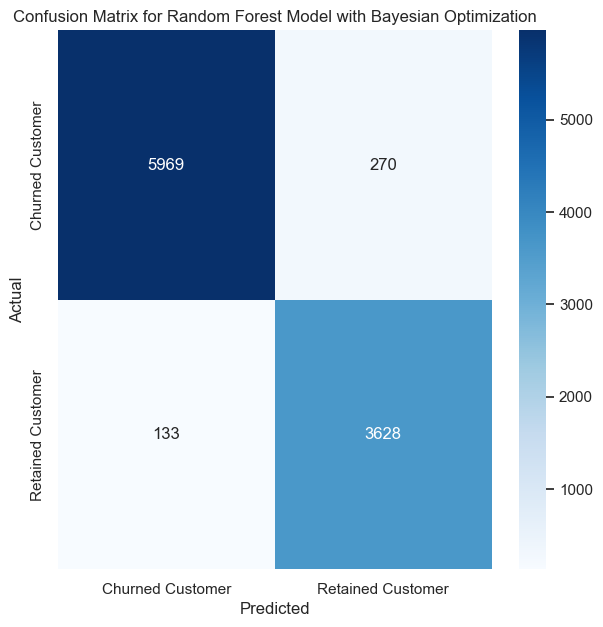

In [80]:
#create a confusion matrix for the random forest model with bayesian optimization
cm_rf_bo_best = confusion_matrix(y_test, y_pred_rf_bo_best)
plt.figure(figsize=(7,7))
sns.heatmap(cm_rf_bo_best, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Churned Customer', 'Retained Customer'],
            yticklabels=['Churned Customer', 'Retained Customer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model with Bayesian Optimization')
plt.show()


Based on our confusion matrix and classification reporting, the model has done a very good job of classifying our customers as retained vs churned. With only 270 false positives in identifying our retained customers, the model performed quite well.  This is corroborated from our classification reporting indicating a precision score of 93% for retained customers.  Likewise, it clearly identified the customers that were not retained. The confusion matrix shows our false negatives as 133 customers, that were predicted to be churned, but were not.  This is corroborated from our classification reporting indicating a recall score of 96%.

As it relates to the model, future improvements would include spending more time addressing the features containing outliers so that other models could be used in comparison.  For example, we would like to use logistic regression and gradient boosting.  As there is a slight imbalance in the majority and minority classes, we could also use resampling methods to reduce that imbalance.  We addressed it within the random forest model with the class_weight parameter; but further improvement could be implemented.  

In [70]:
#extract the feature importances from the random forest model
feature_importances = rf_bo_best.feature_importances_

#store the feature importances in a dataframe sorted by importance
feature_importances_df = pd.DataFrame(
    {'Feature': X_train.columns,
     'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
#print the feature importances
print(feature_importances_df)

                     Feature  Importance
7                     tenure    0.764360
6       avg_rating_by_driver    0.044822
4                weekday_pct    0.032242
3                  surge_pct    0.027041
11       city_King's Landing    0.025260
5                   avg_dist    0.022694
2                  avg_surge    0.019818
1       avg_rating_of_driver    0.017476
0     trips_in_first_30_days    0.013117
9               phone_iPhone    0.012625
8   ultimate_black_user_True    0.010639
10              city_Astapor    0.006328
12           city_Winterfell    0.003577


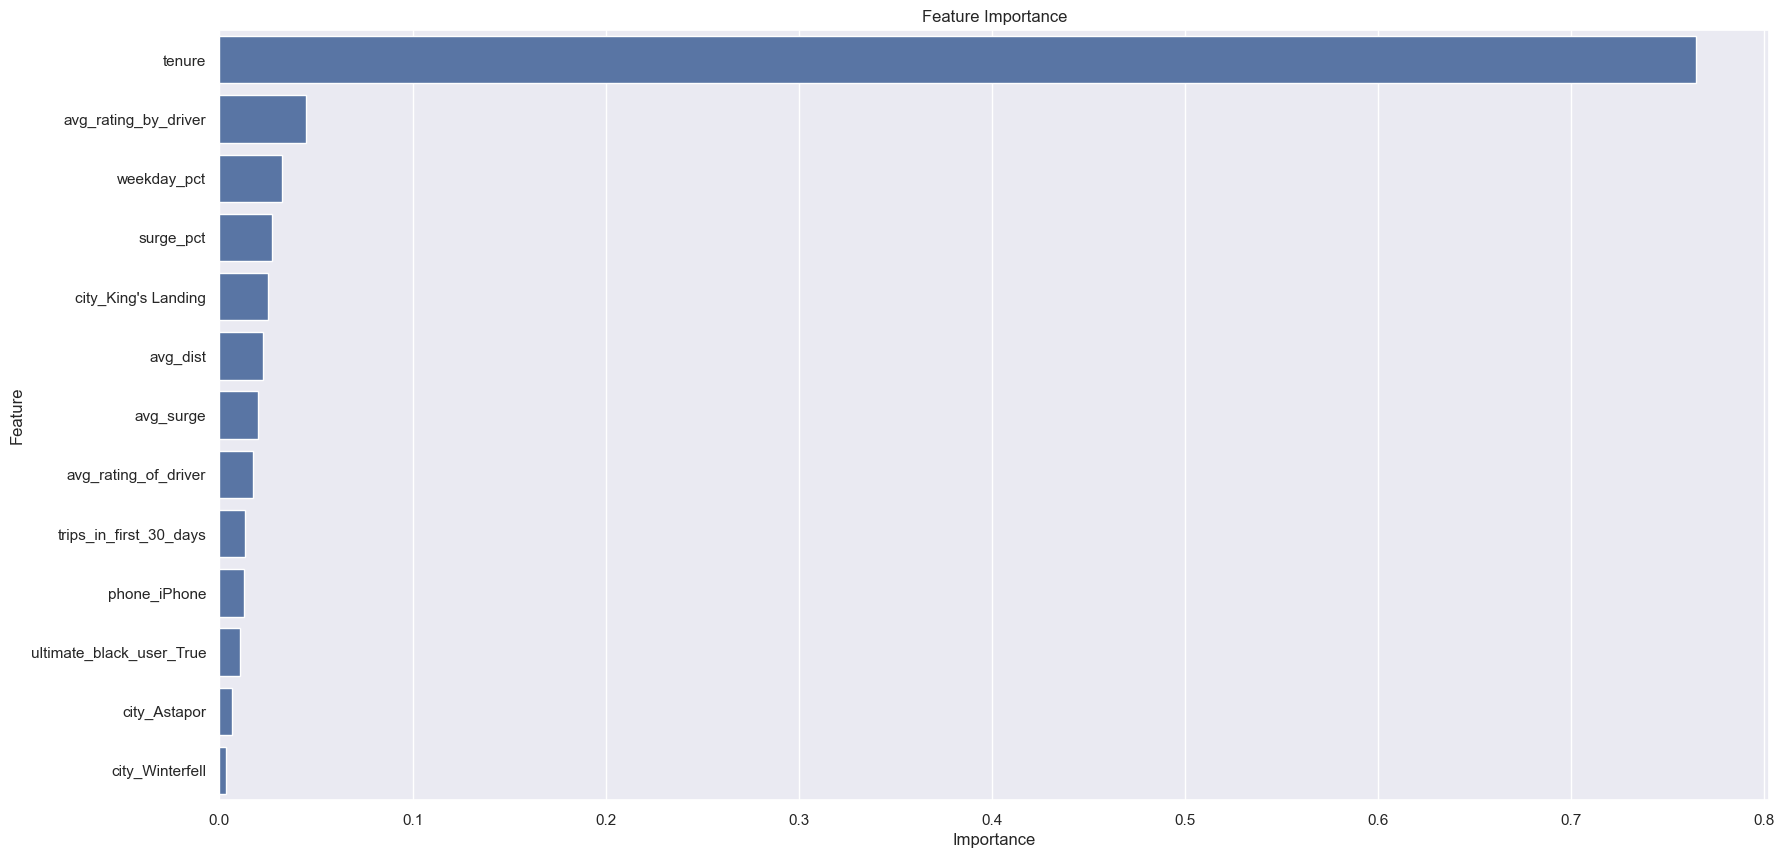

In [71]:
# plot the feature importance in a horizontal bar plot
plt.figure(figsize=(20,10))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importance')
plt.show()   


Tenure is so closely related to retention, that we will set that aside for a moment for business recommendations.  It is our key driver and it is important, however any business improvements must have it in mind as they are implemented.  If we look at the other features' importance, we can see that the avg. rating by the driver is of high importance to the model.  Business leaders could target the riders with high driver ratings with repeat trip discounts or other incentives to further increase their usage and extend their tenure with the Ultimate ride share business.  